<a href="https://colab.research.google.com/github/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/blob/main/PIU_Model_Fitting_With_CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MMAI 869, Smith School of Business at Queens University
###Team Broadview Project, Pump it Up: Data Mining the Water Table

#Install and ImportRequired Libraries

In [2]:
pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 290 kB 24.4 MB/s 


In [3]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 944 kB/s 


In [4]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.9 MB/s 


###Import Libraries

In [5]:
import sys
import numpy as np  
import pandas as pd  
import datetime as dt

# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import plot_roc_curve
from sklearn import metrics

from feature_engine.encoding import RareLabelEncoder

from category_encoders import *
from category_encoders.wrapper import PolynomialWrapper
# from category_encoders import OneHotEncoder, TargetEncoder, JamesSteinEncoder, CatBoostEncoder, MEstimateEncoder, WOEEncoder, LeaveOneOutEncoder

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


### Check Allocated System Specs by Google Colab

In [6]:
from psutil import *

cpu_count()

2

In [7]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [8]:
!df -h / |awk '{print $4}'

Avail
85G


In [9]:
!free -h  --si | awk '/Mem:/{print $2}'

13G


In [10]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [11]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#1. Loading the dataset from GitHub: [MMAI869-Pump-it-Up-Competition]

  Data is accessed from github: (https://github.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition)



In [12]:
train_ulr = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/preprocessed_data.csv'
test_ulr = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/preprocessed_test.csv'
tt_ulr = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/clean.csv'
# ulr_Test_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Test_Set_Values.csv'
data = pd.read_csv(train_ulr)
test = pd.read_csv(test_ulr)
train2 = pd.read_csv(tt_ulr)
# test = pd.read_csv(ulr_Test_Set_Values)
# data = Training_Set_Values.merge(Training_Set_Labels, on='id', how='right')

pd.set_option('display.max_columns', None)

In [13]:
test_id = test.id

In [14]:
data.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_class,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,well_age
0,69572,0.342846,Roman,10.324381,roman,34.938093,-9.856322,Missing,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,0.070822,Yes,VWC,Roman,No,1999.0,gravity,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional,2011,3,0,1,4,12.0
1,8776,0.011417,Grumeti,10.387164,grumeti,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,0.182957,Missing,Other,Missing,Yes,2010.0,gravity,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2013,3,2,1,4,3.0
2,34310,0.001417,Lottery Club,5.413324,world vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,0.163284,Yes,VWC,Nyumba ya mungu pipe scheme,Yes,2009.0,gravity,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,functional,2013,2,0,1,2,4.0
3,67743,0.002846,Unicef,2.462504,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,0.037378,Yes,VWC,Missing,Yes,1986.0,submersible,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,2013,1,0,1,4,27.0
4,19728,0.014274,Action In A,7.995705,artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0.130496,Yes,Missing,Missing,Yes,2003.0,gravity,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,2011,7,2,3,0,8.0


In [15]:
#We keep everything that might have some info for our models

# data.drop(['public_meeting'],axis=1, inplace=True)
# test.drop(['public_meeting'],axis=1, inplace=True)

# data.drop(['permit'],axis=1, inplace=True)
# test.drop(['permit'],axis=1, inplace=True)

#2. Label Distribution and Label Encoding
Multiclass Classification Labels, need to encode them

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Text(0, 0.5, 'Number of Occurance')

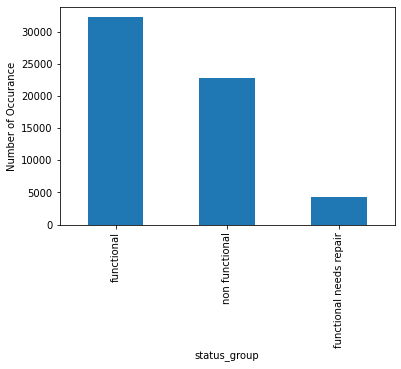

In [16]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

In [17]:
data.status_group.value_counts()


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [18]:
data.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [19]:
label_encouder=LabelEncoder()
data.status_group = label_encouder.fit_transform(data.status_group)
data.status_group.head()

0    0
1    0
2    0
3    2
4    0
Name: status_group, dtype: int64

Text(0, 0.5, 'Number of Occurance')

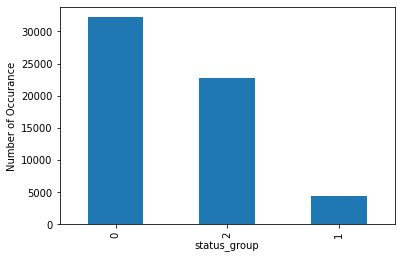

In [20]:
data.status_group.value_counts().plot.bar()
plt.xlabel('status_group')
plt.ylabel('Number of Occurance')

#3. Defining the Encoders for Use in Cross Validation

##3.1. OneHotEncoding

In [21]:
onehot_enc_features = ['permit','public_meeting']


In [22]:
onehot_enc = OneHotEncoder(
    verbose=0,
     cols=onehot_enc_features, 
     drop_invariant=False,
      return_df=True, handle_missing='value', handle_unknown='value', use_cat_names=True
)

In [23]:
onehot_enc.fit(data)

OneHotEncoder(cols=['permit', 'public_meeting'], use_cat_names=True)

In [24]:
data = onehot_enc.transform(data)
test = onehot_enc.transform(test)

In [25]:
data.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting_Yes,public_meeting_Missing,public_meeting_No,scheme_management,scheme_name,permit_No,permit_Yes,permit_Missing,construction_year,extraction_type,extraction_type_class,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,well_age
0,69572,0.342846,Roman,10.324381,roman,34.938093,-9.856322,Missing,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,0.070822,1,0,0,VWC,Roman,1,0,0,1999.0,gravity,gravity,vwc,annually,soft,enough,spring,communal standpipe,0,2011,3,0,1,4,12.0
1,8776,0.011417,Grumeti,10.387164,grumeti,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,0.182957,0,1,0,Other,Missing,0,1,0,2010.0,gravity,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,0,2013,3,2,1,4,3.0
2,34310,0.001417,Lottery Club,5.413324,world vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,0.163284,1,0,0,VWC,Nyumba ya mungu pipe scheme,0,1,0,2009.0,gravity,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,0,2013,2,0,1,2,4.0
3,67743,0.002846,Unicef,2.462504,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,0.037378,1,0,0,VWC,Missing,0,1,0,1986.0,submersible,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,2,2013,1,0,1,4,27.0
4,19728,0.014274,Action In A,7.995705,artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0.130496,1,0,0,Missing,Missing,0,1,0,2003.0,gravity,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,0,2011,7,2,3,0,8.0


##3.2. Rare Value Encoders

In [26]:
variables=data.select_dtypes(include='object').columns
variables

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'scheme_management', 'scheme_name', 'extraction_type',
       'extraction_type_class', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')

In [27]:
for i in variables:
  print(i , 'has', data[i].unique().shape[0],'categories')

funder has 1898 categories
installer has 1936 categories
wpt_name has 37400 categories
basin has 9 categories
subvillage has 19288 categories
region has 21 categories
lga has 125 categories
ward has 2092 categories
scheme_management has 12 categories
scheme_name has 2697 categories
extraction_type has 18 categories
extraction_type_class has 7 categories
management has 12 categories
payment_type has 7 categories
water_quality has 8 categories
quantity has 5 categories
source has 10 categories
waterpoint_type has 7 categories


In [28]:
# data_copy=data.copy()

In [29]:
# rare_encoder_test = RareLabelEncoder(
#   tol=0.002,  # minimal percentage to be considered non-rare
#   n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
#   variables=['scheme_name'], # variables to re-group
#   replace_with='Rare')

In [30]:
# data_copy = rare_encoder_test.fit_transform(data_copy)

In [31]:
# data_copy.scheme_name.value_counts().shape[0]

In [32]:
rare_encoder = RareLabelEncoder(
  tol=0.025,  # minimal percentage to be considered non-rare
  n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
  variables=['scheme_management', 'extraction_type', 'management', 'water_quality', 'source','waterpoint_type'], # variables to re-group
  replace_with='Rare')

rare_encoder_EXtreme_Cardinality = RareLabelEncoder(
  tol=0.007,  # minimal percentage to be considered non-rare
  n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
  max_n_categories = 50,
  # variables=['lga', 'funder'], # variables to re-group
  variables=['funder', 'installer'], # variables to re-group
  replace_with='Rare')

rare_encoder_ExCard_ward = RareLabelEncoder(
  tol=0.002,  # minimal percentage to be considered non-rare
  n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
  max_n_categories = 500,
  variables=['ward', 'wpt_name', 'subvillage', 'scheme_name'], # variables to re-group
  replace_with='Rare')


##3.3. Categorical Encoders
https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark

https://contrib.scikit-learn.org/category_encoders/

https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53



###3.2.1. Target Encoder

In [33]:
tar_train=data.copy()
tar_test=test.copy()

In [34]:
tar_train.drop(['id'],axis=1, inplace=True)
tar_test.drop(['id'],axis=1, inplace=True)

In [35]:
# X = tar_train.drop('status_group', axis=1)

In [36]:
# y = tar_train.status_group
# y=np.array(y)
# y=y.astype(int) 

In [37]:
# X = pd.DataFrame(bunch.data, columns=bunch.feature_names)

In [38]:
tar_enc = TargetEncoder(cols=variables,min_samples_leaf=5, smoothing=20)
# wrapper = PolynomialWrapper(tar_enc)
# encoded = wrapper.fit_transform(X, y)

In [39]:
# encoded.head()

In [40]:
# status_labels =['func', 'non-func' , 'func_repair']

In [41]:
# enc=OneHotEncoder().fit(tar_train.status_group.astype(str))
# status_group_labels=enc.transform(tar_train.status_group.astype(str))
# status_group_labels.columns = status_labels
# status_group_labels.head()

In [42]:
# class_names=status_group_labels.columns[0:3]
# class_names

In [43]:
# variables=tar_train.select_dtypes(include='object').columns
# variables

In [44]:
# target_enc=TargetEncoder(verbose=0, cols=None, drop_invariant=True, return_df=True,
# # handle_missing='value',
# # handle_unknown='value',
# min_samples_leaf=3,
# smoothing=2,
# )

In [45]:

# for var in variables:
#   for class_ in class_names:
#     # print(enc.fit_transform(data,status_group_labels[class_]))
#     target_enc = enc.fit(tar_train[var],status_group_labels[class_])
#     tar_train[var + '_' + class_] = enc.transform(tar_train[var])
#     tar_test[var + '_' + class_] = enc.transform(tar_test[var])

###3.2.2. James_Stein Encoder
https://kiwidamien.github.io/james-stein-encoder.html

In [46]:
js_train=data.copy()
js_test=test.copy()

In [47]:
js_train.drop(['id'],axis=1, inplace=True)
js_test.drop(['id'],axis=1, inplace=True)

In [48]:
# (verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', model='independent', random_state=None, randomized=False, sigma=0.05)
js_enc = JamesSteinEncoder(
    drop_invariant=True,
    model='independent', random_state=7,
    sigma=0.05
)

###3.2.3. CatBoost Encoder
https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/

In [49]:
cb_train=data.copy()
cb_test=test.copy()

In [50]:
cb_train.drop(['id'],axis=1, inplace=True)
cb_test.drop(['id'],axis=1, inplace=True)

In [51]:
# (verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', random_state=None, sigma=None, a=1)
cb_enc = CatBoostEncoder(
    cols=None, drop_invariant=True,
    random_state=7,
)

###3.2.5. Leave One Out Encoder


In [52]:
loo_train=data.copy()
loo_test=test.copy()

In [53]:
loo_train.drop(['id'],axis=1, inplace=True)
loo_test.drop(['id'],axis=1, inplace=True)

In [54]:
loo_enc=LeaveOneOutEncoder(verbose=0, cols=None,drop_invariant=True, return_df=True,
# handle_missing='value',
# handle_unknown='value',
random_state=7
)

###3.2.6. MEstimator Encoder


In [55]:
me_train=data.copy()
me_test=test.copy()

In [56]:
me_train.drop(['id'],axis=1, inplace=True)
me_test.drop(['id'],axis=1, inplace=True)

In [57]:
# (verbose=0, cols=None, drop_invariant=False, return_df=True, handle_unknown='value', handle_missing='value', random_state=None, randomized=False, sigma=0.05, m=1.0)
me_enc=MEstimateEncoder(verbose=0, cols=None,drop_invariant=False, return_df=True,
sigma=0.05, m=1.0,
random_state=7
)

#4. Defining the ML Models

In [58]:
rf_clf = RandomForestClassifier(
          n_estimators = 1000,
          criterion = 'entropy', 
          max_depth = None, # 
          min_samples_split=2,
          min_samples_leaf=1, 
          max_features= 'sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
          max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
          #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
          min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
          bootstrap = True,
          warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
          class_weight = 'balanced',
          max_samples = None,
          verbose = 0,
          n_jobs = -1,
          random_state = 17,
)

In [59]:
# importing the lightgbm module
import lightgbm as lgb
# initializing the model
LightGBM_Clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves = 50,
    max_depth=-1,
    learning_rate = 0.2,
    n_estimators=1000,
    subsample_for_bin=200000,
    objective=None,
    class_weight= None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=17, 
    n_jobs=-1, 
    silent=True, 
    importance_type='split',
    verbosity = 0,
    
)

In [60]:
xgboost_clf = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                learning_rate = 0.09, # range [0,1], typically=0.01-0.2
                n_estimators = 533,
                verbosity = 0,
                objective = "multi:softmax",
                booster = "gbtree", # gblinear or dart
                n_jobs = 1,
                gamma = 0, 
                # Minimum loss reduction required to split. range=[0,inf],
                # The larger gamma is, the more conservative the algorithm will be.
                min_child_weight = 1, # used to restrict overfitting
                max_delta_step = 0,
                subsample = 0.75,
                colsample_bytree = 0.5,
                colsample_bylevel = 0.5,
                colsample_bynode = 0.5,
                reg_alpha = 0,
                reg_lambda = 1,
                scale_pos_weight = 0.5, #[default=1]
                random_state = 17,
                            
)

In [61]:
# dtree = DecisionTreeClassifier(criterion = 'gini', max_depth=9, random_state=17)

# AdaBoost_clf = AdaBoostClassifier(base_estimator=dtree,
#                                   n_estimators= 543,
#                                   learning_rate=0.9,
#                                   algorithm='SAMME.R',
#                                   random_state=7)

In [63]:
# GBoost_clf = GradientBoostingClassifier(
#     learning_rate=0.2,
#     n_estimators=1000, 
#     # subsample=1.0, 
#      max_depth=8, 
#      random_state=17, 
# )

In [64]:
CatBoost_clf = CatBoostClassifier(
    n_estimators=1000, 
    max_depth=8,
    random_state=17, 
    verbose=0
)


#5.1 Feature Engineering and Modeling within Cross Validation - Target Encoding

In [197]:
# Use the results of any categorical encoding that you chose

train = tar_train.copy()
test = tar_test.copy()

In [198]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [199]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=17)

Streaming output truncated to the last 5000 lines.
35:	learn: 0.5840698	total: 4.57s	remaining: 2m 2s
36:	learn: 0.5820397	total: 4.69s	remaining: 2m 2s
37:	learn: 0.5805532	total: 4.81s	remaining: 2m 1s
38:	learn: 0.5787786	total: 4.94s	remaining: 2m 1s
39:	learn: 0.5773455	total: 5.05s	remaining: 2m 1s
40:	learn: 0.5754302	total: 5.18s	remaining: 2m 1s
41:	learn: 0.5736396	total: 5.3s	remaining: 2m
42:	learn: 0.5718144	total: 5.42s	remaining: 2m
43:	learn: 0.5708815	total: 5.55s	remaining: 2m
44:	learn: 0.5699058	total: 5.68s	remaining: 2m
45:	learn: 0.5686609	total: 5.8s	remaining: 2m
46:	learn: 0.5670172	total: 5.93s	remaining: 2m
47:	learn: 0.5652038	total: 6.05s	remaining: 1m 59s
48:	learn: 0.5638792	total: 6.18s	remaining: 1m 59s
49:	learn: 0.5625006	total: 6.31s	remaining: 1m 59s
50:	learn: 0.5614772	total: 6.43s	remaining: 1m 59s
51:	learn: 0.5598881	total: 6.56s	remaining: 1m 59s
52:	learn: 0.5590790	total: 6.68s	remaining: 1m 59s
53:	learn: 0.5579486	total: 6.8s	remaining: 1

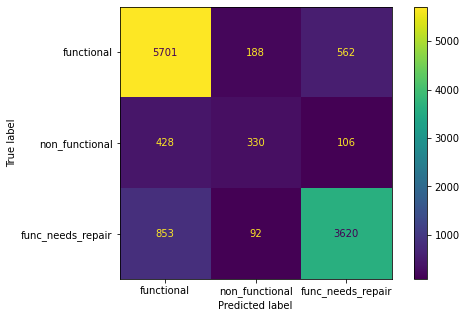

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.52      0.36      0.42       864
           2       0.84      0.79      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.72      0.68      0.69     11880
weighted avg       0.80      0.81      0.80     11880



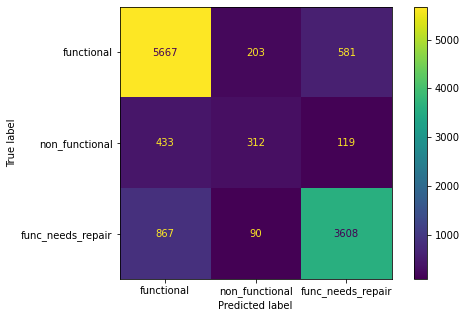

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6451
           1       0.59      0.33      0.42       864
           2       0.85      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.75      0.67      0.70     11880
weighted avg       0.81      0.81      0.81     11880



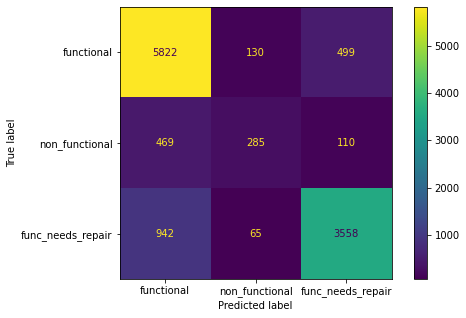

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6451
           1       0.61      0.31      0.41       864
           2       0.84      0.77      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.75      0.66      0.69     11880
weighted avg       0.80      0.81      0.80     11880



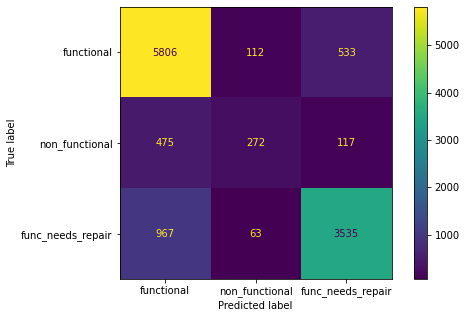

In [200]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0
mean_acc_GB = 0
mean_acc_CatBoost = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # rare_enc_X_train = rare_encoder.transform(X_train)
    X_train = rare_encoder_EXtreme_Cardinality.transform(X_train)
    X_train = rare_encoder_ExCard_ward.transform(X_train)

    # rare_enc_X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(tar_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)
  


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

# #adaboost
#     AdaBoost_clf.fit(X_train, y_train)
#     y_pred_AdaBoost = AdaBoost_clf.predict(X_test)
#     AdaBoost_accuracy = metrics.accuracy_score(y_test, y_pred_AdaBoost)
#     mean_acc_ada += AdaBoost_accuracy
#     print(f'AdaBoost_accuracy: {AdaBoost_accuracy, split+1}')

# #GBboost
#     GBoost_clf.fit(X_train, y_train)
#     y_pred_GBoost = GBoost_clf.predict(X_test)
#     GBoost_clf_accuracy = metrics.accuracy_score(y_test, y_pred_GBoost)
#     mean_acc_GB += GBoost_clf_accuracy
#     print(f'GBoost_accuracy: {GBoost_clf_accuracy, split+1}')

#catboost
    CatBoost_clf.fit(X_train, y_train)
    y_pred_CatBoost = CatBoost_clf.predict(X_test)
    CatBoost_clf_accuracy = metrics.accuracy_score(y_test, y_pred_CatBoost)
    mean_acc_CatBoost += CatBoost_clf_accuracy
    print(f'CatBoost_accuracy: {CatBoost_clf_accuracy, split+1}')



    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)
# print('GBoost accuracy is' ,mean_acc_GB/n_splits)
print('CatBoost accuracy is' ,mean_acc_CatBoost/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();


# print(classification_report(y_test, y_pred_GBoost))
# # Plot confusion matrix for random Forest
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_GBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();


print(classification_report(y_test, y_pred_CatBoost))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_CatBoost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [216]:
test.drop('status_group', axis=1, inplace=True)

In [217]:
test.drop('id', axis=1, inplace=True)

In [218]:
test = rare_encoder_EXtreme_Cardinality.transform(test)
test = rare_encoder_ExCard_ward.transform(test)
test = wrapper.transform(test)

y_pred_rf_target = rf_clf.predict(test)
tar_test_RFoutput=test.copy()
tar_test_RFoutput['status_group'] = y_pred_rf_target
tar_test_RFoutput['id']=test_id
tar_test_RFoutput['status_group'] = tar_test_RFoutput['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_XGBoost_target = xgboost_clf.predict(test)
tar_test_XGBoost=test.copy()
tar_test_XGBoost['status_group'] = y_pred_XGBoost_target
tar_test_XGBoost['id']=test_id
tar_test_XGBoost['status_group'] = tar_test_XGBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_LightGBM_target = LightGBM_Clf.predict(test)
tar_test_LightGBM=test.copy()
tar_test_LightGBM['status_group'] = y_pred_LightGBM_target
tar_test_LightGBM['id']=test_id
tar_test_LightGBM['status_group'] = tar_test_LightGBM['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_CatBoost_target = CatBoost_clf.predict(test)
tar_test_CatBoost=test.copy()
tar_test_CatBoost['status_group'] = y_pred_CatBoost_target
tar_test_CatBoost['id']=test_id
tar_test_CatBoost['status_group'] = tar_test_CatBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})

In [219]:
from google.colab import drive
drive.mount('drive', force_remount=True)
tar_test_RFoutput[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/tar_RFoutput.csv', encoding='utf-8', index=False, header=True)
tar_test_XGBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/tar_XGBoost.csv', encoding='utf-8', index=False, header=True)
tar_test_LightGBM[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/tar_LightGBM.csv', encoding='utf-8', index=False, header=True)
tar_test_CatBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/tar_CatBoost.csv', encoding='utf-8', index=False, header=True)

Mounted at drive


#5.2 Feature Engineering and Modeling within Cross Validation - CatBoost Encoding

In [ ]:
# Use the results of any categorical encoding that you chose

train = cb_train.copy()
test = cb_test.copy()

In [ ]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [ ]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.7882996632996633, 1)
LightGBM_accuracy: (0.7843434343434343, 1)
xgboost_accuracy: (0.7870370370370371, 1)
>>>rf_Accuracy: (0.7888888888888889, 2)
LightGBM_accuracy: (0.7895622895622896, 2)
xgboost_accuracy: (0.7897306397306397, 2)
>>>rf_Accuracy: (0.7940235690235691, 3)
LightGBM_accuracy: (0.7930976430976431, 3)
xgboost_accuracy: (0.796043771043771, 3)
>>>rf_Accuracy: (0.786952861952862, 4)
LightGBM_accuracy: (0.7926767676767676, 4)
xgboost_accuracy: (0.7839225589225589, 4)
>>>rf_Accuracy: (0.7894781144781144, 5)
LightGBM_accuracy: (0.7906565656565656, 5)
xgboost_accuracy: (0.7877946127946128, 5)
Random Forest accuracy is 0.7895286195286195
Light GBM accuracy is 0.7900673400673399
XGBoost accuracy is 0.7889057239057239
              precision    recall  f1-score   support

           0       0.77      0.92      0.83      6451
           1       0.69      0.22      0.33       864
           2       0.84      0.72      0.78      4565

    accuracy                      

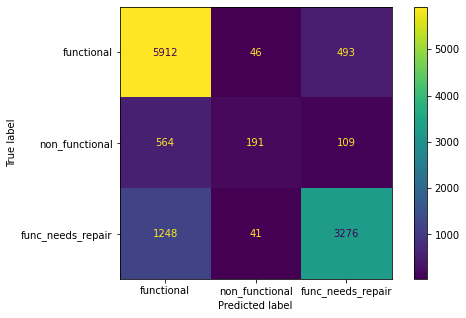

              precision    recall  f1-score   support

           0       0.77      0.91      0.83      6451
           1       0.71      0.20      0.32       864
           2       0.83      0.74      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.77      0.62      0.64     11880
weighted avg       0.79      0.79      0.78     11880



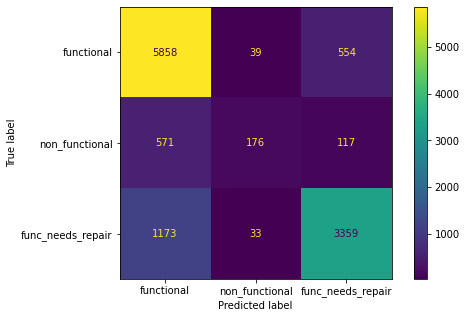

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      6451
           1       0.72      0.18      0.29       864
           2       0.85      0.71      0.77      4565

    accuracy                           0.79     11880
   macro avg       0.78      0.61      0.63     11880
weighted avg       0.79      0.79      0.77     11880



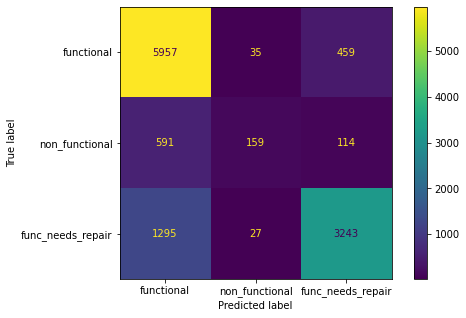

In [ ]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0
mean_acc_GB = 0
mean_acc_CatBoost = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # X_train = rare_encoder.transform(X_train)
    X_train = rare_encoder_EXtreme_Cardinality.transform(X_train)
    X_train = rare_encoder_ExCard_ward.transform(X_train)

    # X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(cb_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

# #adaboost
#     AdaBoost_clf.fit(X_train, y_train)
#     y_pred_AdaBoost = rf_clf.predict(X_test)
#     AdaBoost_accuracy = metrics.accuracy_score(y_test, y_pred_AdaBoost)
#     mean_acc_ada += AdaBoost_accuracy
#     print(f'AdaBoostt_accuracy: {AdaBoost_accuracy, split+1}')


# #GBboost
#     GBoost_clf.fit(X_train, y_train)
#     y_pred_GBoost = GBoost_clf.predict(X_test)
#     GBoost_clf_accuracy = metrics.accuracy_score(y_test, y_pred_GBoost)
#     mean_acc_GB += GBoost_clf_accuracy
#     print(f'GBoost_accuracy: {GBoost_clf_accuracy, split+1}')

#catboost
    CatBoost_clf.fit(X_train, y_train)
    y_pred_CatBoost = CatBoost_clf.predict(X_test)
    CatBoost_clf_accuracy = metrics.accuracy_score(y_test, y_pred_CatBoost)
    mean_acc_CatBoost += CatBoost_clf_accuracy
    print(f'CatBoost_accuracy: {CatBoost_clf_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)
# print('GBoost accuracy is' ,mean_acc_GB/n_splits)
print('CatBoost accuracy is' ,mean_acc_CatBoost/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

# print(classification_report(y_test, y_pred_GBoost))
# # Plot confusion matrix for random Forest
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_GBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();


print(classification_report(y_test, y_pred_CatBoost))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_CatBoost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
test = rare_encoder_EXtreme_Cardinality.transform(test)
test = rare_encoder_ExCard_ward.transform(test)
test = wrapper.transform(test)

y_pred_rf_target = rf_clf.predict(test)
cb_test_RFoutput=test.copy()
cb_test_RFoutput['status_group'] = y_pred_rf_target
cb_test_RFoutput['id']=test_id
cb_test_RFoutput['status_group'] = cb_test_RFoutput['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_XGBoost_target = xgboost_clf.predict(test)
cb_test_XGBoost=test.copy()
cb_test_XGBoost['status_group'] = y_pred_XGBoost_target
cb_test_XGBoost['id']=test_id
cb_test_XGBoost['status_group'] = cb_test_XGBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_LightGBM_target = LightGBM_Clf.predict(test)
cb_test_LightGBM=test.copy()
cb_test_LightGBM['status_group'] = y_pred_LightGBM_target
cb_test_LightGBM['id']=test_id
cb_test_LightGBM['status_group'] = cb_test_LightGBM['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_CatBoost_target = CatBoost_clf.predict(test)
cb_test_CatBoost=test.copy()
cb_test_CatBoost['status_group'] = y_pred_CatBoost_target
cb_test_CatBoost['id']=test_id
cb_test_CatBoost['status_group'] = cb_test_CatBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})

In [ ]:
from google.colab import drive
drive.mount('drive', force_remount=True)
cb_test_RFoutput[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/cb_RFoutput.csv', encoding='utf-8', index=False, header=True)
cb_test_XGBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/cb_XGBoost.csv', encoding='utf-8', index=False, header=True)
cb_test_LightGBM[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/cb_LightGBM.csv', encoding='utf-8', index=False, header=True)
cb_test_CatBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/cb_CatBoost.csv', encoding='utf-8', index=False, header=True)

#5.4 Feature Engineering and Modeling within Cross Validation - LeaveOneOut Encoding

In [ ]:
# Use the results of any categorical encoding that you chose

train = loo_train.copy()
test = loo_test.copy()

In [ ]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [ ]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.5476430976430976, 1)
LightGBM_accuracy: (0.5458754208754208, 1)
xgboost_accuracy: (0.5541245791245791, 1)
>>>rf_Accuracy: (0.5492424242424242, 2)
LightGBM_accuracy: (0.546043771043771, 2)
xgboost_accuracy: (0.5512626262626262, 2)
>>>rf_Accuracy: (0.5489057239057239, 3)
LightGBM_accuracy: (0.5484848484848485, 3)
xgboost_accuracy: (0.5537037037037037, 3)
>>>rf_Accuracy: (0.5505892255892256, 4)
LightGBM_accuracy: (0.546043771043771, 4)
xgboost_accuracy: (0.553956228956229, 4)
>>>rf_Accuracy: (0.548989898989899, 5)
LightGBM_accuracy: (0.546969696969697, 5)
xgboost_accuracy: (0.5527777777777778, 5)
Random Forest accuracy is 0.549074074074074
Light GBM accuracy is 0.5466835016835017
XGBoost accuracy is 0.5531649831649832
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      6451
           1       0.00      0.00      0.00       864
           2       0.85      0.02      0.04      4565

    accuracy                          

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


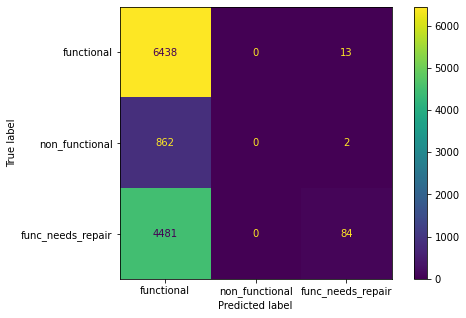

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      1.00      0.71      6451
           1       0.00      0.00      0.00       864
           2       0.75      0.01      0.03      4565

    accuracy                           0.55     11880
   macro avg       0.43      0.34      0.24     11880
weighted avg       0.59      0.55      0.39     11880



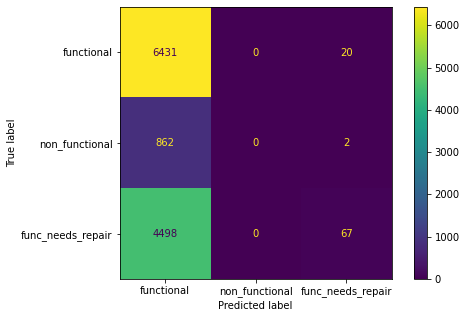

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      1.00      0.71      6451
           1       0.00      0.00      0.00       864
           2       0.95      0.03      0.05      4565

    accuracy                           0.55     11880
   macro avg       0.50      0.34      0.25     11880
weighted avg       0.66      0.55      0.40     11880



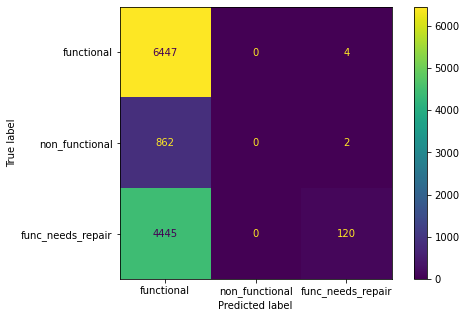

In [ ]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0
mean_acc_GB = 0
mean_acc_CatBoost = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_test)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # X_test = rare_encoder.transform(X_train)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    # X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(loo_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

# #adaboost
#     AdaBoost_clf.fit(X_train, y_train)
#     y_pred_AdaBoost = rf_clf.predict(X_test)
#     AdaBoost_accuracy = metrics.accuracy_score(y_test, y_pred_AdaBoost)
#     mean_acc_ada += AdaBoost_accuracy
#     print(f'AdaBoostt_accuracy: {AdaBoost_accuracy, split+1}')


# #GBboost
#     GBoost_clf.fit(X_train, y_train)
#     y_pred_GBoost = GBoost_clf.predict(X_test)
#     GBoost_clf_accuracy = metrics.accuracy_score(y_test, y_pred_GBoost)
#     mean_acc_GB += GBoost_clf_accuracy
#     print(f'GBoost_accuracy: {GBoost_clf_accuracy, split+1}')

#catboost
    CatBoost_clf.fit(X_train, y_train)
    y_pred_CatBoost = CatBoost_clf.predict(X_test)
    CatBoost_clf_accuracy = metrics.accuracy_score(y_test, y_pred_CatBoost)
    mean_acc_CatBoost += CatBoost_clf_accuracy
    print(f'CatBoost_accuracy: {CatBoost_clf_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)
# print('GBoost accuracy is' ,mean_acc_GB/n_splits)
print('CatBoost accuracy is' ,mean_acc_CatBoost/n_splits)



print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();


# print(classification_report(y_test, y_pred_GBoost))
# # Plot confusion matrix for random Forest
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_GBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();


print(classification_report(y_test, y_pred_CatBoost))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_CatBoost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
test = rare_encoder_EXtreme_Cardinality.transform(test)
test = rare_encoder_ExCard_ward.transform(test)
test = wrapper.transform(test)


y_pred_rf_target = rf_clf.predict(test)
loo_test_RFoutput=test.copy()
loo_test_RFoutput['status_group'] = y_pred_rf_target
loo_test_RFoutput['id']=test_id
loo_test_RFoutput['status_group'] = loo_test_RFoutput['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_XGBoost_target = xgboost_clf.predict(test)
loo_test_XGBoost=test.copy()
loo_test_XGBoost['status_group'] = y_pred_XGBoost_target
loo_test_XGBoost['id']=test_id
loo_test_XGBoost['status_group'] = loo_test_XGBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_LightGBM_target = LightGBM_Clf.predict(test)
loo_test_LightGBM=test.copy()
loo_test_LightGBM['status_group'] = y_pred_LightGBM_target
loo_test_LightGBM['id']=test_id
loo_test_LightGBM['status_group'] = loo_test_LightGBM['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_CatBoost_target = CatBoost_clf.predict(test)
loo_test_CatBoost=test.copy()
loo_test_CatBoost['status_group'] = y_pred_CatBoost_target
loo_test_CatBoost['id']=test_id
loo_test_CatBoost['status_group'] = loo_test_CatBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})

In [ ]:
from google.colab import drive
drive.mount('drive', force_remount=True)
loo_test_RFoutput[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/loo_RFoutput.csv', encoding='utf-8', index=False, header=True)
loo_test_XGBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/loo_XGBoost.csv', encoding='utf-8', index=False, header=True)
loo_test_LightGBM[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/loo_LightGBM.csv', encoding='utf-8', index=False, header=True)
loo_test_CatBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/loo_CatBoost.csv', encoding='utf-8', index=False, header=True)

#5.5 Feature Engineering and Modeling within Cross Validation - MEstimate Encoding

In [74]:
# Use the results of any categorical encoding that you chose

train = me_train.copy()
test = me_test.copy()

In [75]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [76]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

In [ ]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0
mean_acc_GB = 0
mean_acc_CatBoost = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # X_train = rare_encoder.transform(X_train)
    X_train = rare_encoder_EXtreme_Cardinality.transform(X_train)
    X_train = rare_encoder_ExCard_ward.transform(X_train)

    # X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(me_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

# #adaboost
#     AdaBoost_clf.fit(X_train, y_train)
#     y_pred_AdaBoost = rf_clf.predict(X_test)
#     AdaBoost_accuracy = metrics.accuracy_score(y_test, y_pred_AdaBoost)
#     mean_acc_ada += AdaBoost_accuracy
#     print(f'AdaBoostt_accuracy: {AdaBoost_accuracy, split+1}')


# #catboost
#     CatBoost_clf.fit(X_train, y_train)
#     y_pred_CatBoost = CatBoost_clf.predict(X_test)
#     CatBoost_clf_accuracy = metrics.accuracy_score(y_test, y_pred_CatBoost)
#     mean_acc_CatBoost += CatBoost_clf_accuracy
#     print(f'CatBoost_accuracy: {CatBoost_clf_accuracy, split+1}')


    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)
# print('GBoost accuracy is' ,mean_acc_GB/n_splits)
print('CatBoost accuracy is' ,mean_acc_CatBoost/n_splits)


print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();


# print(classification_report(y_test, y_pred_GBoost))
# # Plot confusion matrix for random Forest
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_GBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();


# print(classification_report(y_test, y_pred_CatBoost))
# # Plot confusion matrix for random Forest
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_CatBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();

>>>rf_Accuracy: (0.8108585858585858, 1)
LightGBM_accuracy: (0.8082491582491582, 1)
xgboost_accuracy: (0.8155723905723906, 1)
>>>rf_Accuracy: (0.8072390572390572, 2)


In [ ]:
test = rare_encoder_EXtreme_Cardinality.transform(test)
test = rare_encoder_ExCard_ward.transform(test)
test = wrapper.transform(test)

y_pred_rf_target = rf_clf.predict(test)
me_test_RFoutput=test.copy()
me_test_RFoutput['status_group'] = y_pred_rf_target
me_test_RFoutput['id']=test_id
me_test_RFoutput['status_group'] = me_test_RFoutput['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_XGBoost_target = xgboost_clf.predict(test)
me_test_XGBoost=test.copy()
me_test_XGBoost['status_group'] = y_pred_XGBoost_target
me_test_XGBoost['id']=test_id
me_test_XGBoost['status_group'] = me_test_XGBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_LightGBM_target = LightGBM_Clf.predict(test)
me_test_LightGBM=test.copy()
me_test_LightGBM['status_group'] = y_pred_LightGBM_target
me_test_LightGBM['id']=test_id
me_test_LightGBM['status_group'] = me_test_LightGBM['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


# y_pred_CatBoost_target = CatBoost_clf.predict(test)
# me_test_CatBoost=test.copy()
# me_test_CatBoost['status_group'] = y_pred_CatBoost_target
# me_test_CatBoost['id']=test_id
# me_test_CatBoost['status_group'] = me_test_CatBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})

In [ ]:
from google.colab import drive
drive.mount('drive', force_remount=True)
me_test_RFoutput[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/me_RFoutput.csv', encoding='utf-8', index=False, header=True)
me_test_XGBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/me_XGBoost.csv', encoding='utf-8', index=False, header=True)
me_test_LightGBM[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/me_LightGBM.csv', encoding='utf-8', index=False, header=True)
# me_test_CatBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/me_CatBoost.csv', encoding='utf-8', index=False, header=True)

#5.6 Feature Engineering and Modeling within Cross Validation - James-Stein Encoding

In [ ]:
# Use the results of any categorical encoding that you chose

train = js_train.copy()
test = js_test.copy()

In [ ]:
X = train.drop('status_group',axis=1)
y = train.status_group

In [ ]:
n_repeats =1
n_splits = 5
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=0)

>>>rf_Accuracy: (0.8084175084175084, 1)
LightGBM_accuracy: (0.8052188552188552, 1)
xgboost_accuracy: (0.8132154882154882, 1)
>>>rf_Accuracy: (0.8041245791245791, 2)
LightGBM_accuracy: (0.8015993265993266, 2)
xgboost_accuracy: (0.8082491582491582, 2)
>>>rf_Accuracy: (0.8094276094276094, 3)
LightGBM_accuracy: (0.8042087542087543, 3)
xgboost_accuracy: (0.814057239057239, 3)
>>>rf_Accuracy: (0.8085016835016835, 4)
LightGBM_accuracy: (0.8045454545454546, 4)
xgboost_accuracy: (0.8102693602693603, 4)
>>>rf_Accuracy: (0.810016835016835, 5)
LightGBM_accuracy: (0.8057239057239057, 5)
xgboost_accuracy: (0.8133838383838384, 5)
Random Forest accuracy is 0.8080976430976431
Light GBM accuracy is 0.8042592592592592
XGBoost accuracy is 0.8118350168350169
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      6451
           1       0.55      0.37      0.44       864
           2       0.84      0.79      0.81      4565

    accuracy                      

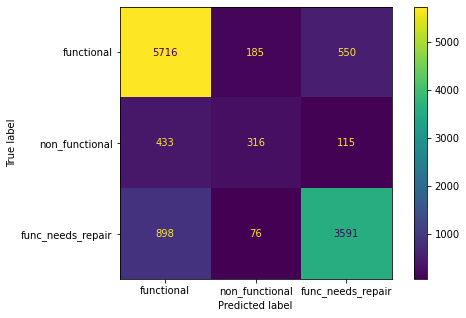

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6451
           1       0.53      0.36      0.42       864
           2       0.83      0.79      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.81      0.80     11880



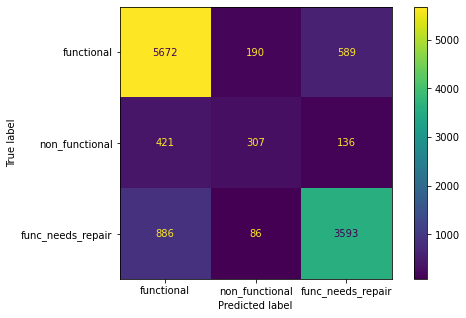

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      6451
           1       0.62      0.32      0.43       864
           2       0.85      0.78      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.76      0.67      0.70     11880
weighted avg       0.81      0.81      0.81     11880



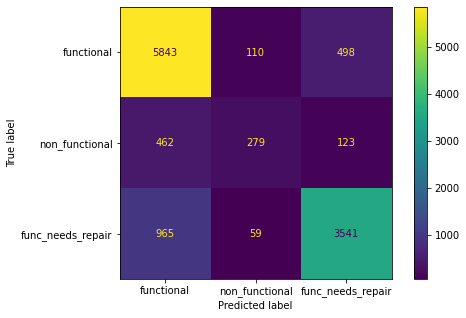

In [ ]:

split = 0
mean_acc_rf = 0
mean_acc_lgbm = 0
mean_acc_xgb = 0
mean_acc_ada = 0
mean_acc_GB = 0
mean_acc_CatBoost = 0

for train_index, test_index in rskf.split(X, y):
    
    # Print a dot for each train / test partition
    sys.stdout.write('>>>')
    sys.stdout.flush()
    
    #Test & train split insode the CV
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #Fitting the rare value encoders
    # rare_encoder.fit(X_train)
    rare_encoder_EXtreme_Cardinality.fit(X_train)
    rare_encoder_ExCard_ward.fit(X_train)

    # X_train = rare_encoder.transform(X_train)
    X_train = rare_encoder_EXtreme_Cardinality.transform(X_train)
    X_train = rare_encoder_ExCard_ward.transform(X_train)

    # X_test = rare_encoder.transform(X_test)
    X_test = rare_encoder_EXtreme_Cardinality.transform(X_test)
    X_test = rare_encoder_ExCard_ward.transform(X_test)

    #Fitting the Categorical encoders
    wrapper = PolynomialWrapper(js_enc)
    X_train = wrapper.fit_transform(X_train, np.array(y_train))
    X_test = wrapper.transform(X_test)


##Fitting Models:

# Random Forest
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    mean_acc_rf += rf_accuracy
    print(f'rf_Accuracy: {rf_accuracy, split+1}')

# LightGBM
    LightGBM_Clf.fit(X_train, y_train)
    y_pred_LightGBM = LightGBM_Clf.predict(X_test)
    LightGBM_accuracy = metrics.accuracy_score(y_test, y_pred_LightGBM)
    mean_acc_lgbm += LightGBM_accuracy
    print(f'LightGBM_accuracy: {LightGBM_accuracy, split+1}')

#xgboost
    xgboost_clf.fit(X_train, y_train)
    y_pred_xgboost = xgboost_clf.predict(X_test)
    xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
    mean_acc_xgb += xgboost_accuracy
    print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

# #adaboost
#     AdaBoost_clf.fit(X_train, y_train)
#     y_pred_rf = rf_clf.predict(X_test)
#     AdaBoost_accuracy = metrics.accuracy_score(y_test, y_pred_AdaBoost)
#     mean_acc_ada += AdaBoost_accuracy
#     print(f'AdaBoostt_accuracy: {AdaBoost_accuracy, split+1}')


# #xgboost
#     xgboost_clf.fit(X_train, y_train)
#     y_pred_xgboost = xgboost_clf.predict(X_test)
#     xgboost_accuracy = metrics.accuracy_score(y_test, y_pred_xgboost)
#     mean_acc_xgb += xgboost_accuracy
#     print(f'xgboost_accuracy: {xgboost_accuracy, split+1}')

#catboost
    CatBoost_clf.fit(X_train, y_train)
    y_pred_CatBoost = CatBoost_clf.predict(X_test)
    CatBoost_clf_accuracy = metrics.accuracy_score(y_test, y_pred_CatBoost)
    mean_acc_CatBoost += CatBoost_clf_accuracy
    print(f'CatBoost_accuracy: {CatBoost_clf_accuracy, split+1}')

    split +=1 

print('Random Forest accuracy is' ,mean_acc_rf/n_splits)
print('Light GBM accuracy is' ,mean_acc_lgbm/n_splits)
print('XGBoost accuracy is' ,mean_acc_xgb/n_splits)
# print('AdaBoosting accuracy is' ,mean_acc_ada/n_splits)
# print('GBoost accuracy is' ,mean_acc_GB/n_splits)
print('CatBoost accuracy is' ,mean_acc_CatBoost/n_splits)



print(classification_report(y_test, y_pred_rf))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_LightGBM))
# Plot confusion matrix for LightGBM
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_LightGBM),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


print(classification_report(y_test, y_pred_xgboost))
# Plot confusion matrix for XGBoost
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_xgboost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();


# print(classification_report(y_test, y_pred_AdaBoost))
# # Plot confusion matrix for AdaBoost
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_AdaBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();


# print(classification_report(y_test, y_pred_GBoost))
# # Plot confusion matrix for random Forest
# fig, ax = plt.subplots(figsize=(8, 5))
# cmp = ConfusionMatrixDisplay(
#     confusion_matrix(y_test, y_pred_GBoost),
#     display_labels=["functional", "non_functional", "func_needs_repair"],
# )

# cmp.plot(ax=ax)
# plt.show();


print(classification_report(y_test, y_pred_CatBoost))
# Plot confusion matrix for random Forest
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_CatBoost),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
test = rare_encoder_EXtreme_Cardinality.transform(test)
test = rare_encoder_ExCard_ward.transform(test)
test = wrapper.transform(test)


y_pred_rf_target = rf_clf.predict(test)
js_test_RFoutput=test.copy()
js_test_RFoutput['status_group'] = y_pred_rf_target
js_test_RFoutput['id']=test_id
js_test_RFoutput['status_group'] = js_test_RFoutput['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_XGBoost_target = xgboost_clf.predict(test)
js_test_XGBoost=test.copy()
js_test_XGBoost['status_group'] = y_pred_XGBoost_target
js_test_XGBoost['id']=test_id
js_test_XGBoost['status_group'] = js_test_XGBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_LightGBM_target = LightGBM_Clf.predict(test)
js_test_LightGBM=test.copy()
js_test_LightGBM['status_group'] = y_pred_LightGBM_target
js_test_LightGBM['id']=test_id
js_test_LightGBM['status_group'] = js_test_LightGBM['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})


y_pred_CatBoost_target = CatBoost_clf.predict(test)
js_test_CatBoost=test.copy()
js_test_CatBoost['status_group'] = y_pred_CatBoost_target
js_test_CatBoost['id']=test_id
js_test_CatBoost['status_group'] = js_test_CatBoost['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})

In [ ]:
from google.colab import drive
drive.mount('drive', force_remount=True)
js_test_RFoutput[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/js_RFoutput.csv', encoding='utf-8', index=False, header=True)
js_test_XGBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/js_XGBoost.csv', encoding='utf-8', index=False, header=True)
js_test_LightGBM[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/js_LightGBM.csv', encoding='utf-8', index=False, header=True)
js_test_CatBoost[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/js_CatBoost.csv', encoding='utf-8', index=False, header=True)

# Hyperparameter Tuning the ML Models

In [304]:
hyp_data=data.drop('id',axis=1)

In [306]:
x_train_hyp, x_valid_hyp, y_train_hyp, y_valid_hyp = train_test_split(hyp_data.drop(['status_group'],axis=1),hyp_data.status_group, random_state = 17, test_size = 0.2, stratify = hyp_data.status_group, shuffle=True)
x_train_hyp.shape, x_valid_hyp.shape, y_train_hyp.shape, y_valid_hyp.shape

((47520, 38), (11880, 38), (47520,), (11880,))

In [307]:
    #Fitting the rare value encoders
    rare_encoder_EXtreme_Cardinality.fit_transform(x_train_hyp)
    rare_encoder_ExCard_ward.fit_transform(x_train_hyp)

    # X_test = rare_encoder.transform(X_test)
    x_valid_hyp = rare_encoder_EXtreme_Cardinality.transform(x_valid_hyp)
    x_valid_hyp = rare_encoder_ExCard_ward.transform(x_valid_hyp)

    wrapper = PolynomialWrapper(me_enc)
    x_train_hyp = wrapper.fit_transform(x_train_hyp, np.array(y_train_hyp))
    x_valid_hyp = wrapper.transform(x_valid_hyp)

In [302]:
model = RandomForestClassifier(min_samples_leaf=5)

# creating a dict of grids
grid = dict()
grid['n_estimators'] = np.arange(400,1200)
grid['criterion'] = ['gini','entropy']
grid['max_depth'] = [3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)

# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = model
                                 , param_distributions=grid
                                 , n_iter=20
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 3 #to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train_hyp, y_train_hyp)

# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score for Random Forest: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

In [ ]:
# defiing the model
model = XGBClassifier( 
                      verbosity = 2,
                      objective = "multi:softmax",
                      booster = "gbtree", # gblinear or dart
                      n_jobs = -1,
                      colsample_bytree = 0.5, 
                      colsample_bylevel = 0.5,
                      colsample_bynode = 0.5,
                      scale_pos_weight = 0.6, #[default=1] 
                      random_state = 17)

# creating a dict of grids
grid = dict()
# values for iteration
grid['n_estimators'] = np.arange(400,1200)

# values for learning rate
grid['learning_rate'] = np.arange(0.05, 1, 0.025)

# values for the sample
grid['subsample'] = np.arange(0.05, 1, 0.025)

# values for teh depth of tree
grid['max_depth'] = [4, 5, 6, 7, 8, 9, 10]

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)

# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = model
                                 , param_distributions=grid
                                 , n_iter=20
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 3 #to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train_hyp, y_train_hyp)

# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score for XGBoost: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

In [ ]:
# defiing the model
dtree = DecisionTreeClassifier(max_depth = 9 , criterion = 'gini', random_state=17)

ada_model = AdaBoostClassifier( base_estimator = dtree,
                            algorithm='SAMME.R',
                            random_state = 17,)


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = np.arange(400,1200)

# values for learning rate
grid['learning_rate'] = np.arange(0.05, 1, 0.025)

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)

# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = ada_model
                                 , param_distributions=grid
                                 , n_iter=20
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 3 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train_hyp, y_train_hyp)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score for ADAboost: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

In [309]:
import lightgbm as lgb
# defiing the model
model = lgb.LGBMClassifier(
    # num_leaves=31, 
    # max_depth=-1, 
    # learning_rate=0.1, 
    # n_estimators=100, 
    class_weight='balanced', 
    subsample=1.0, 
    random_state=17
)

# creating a dict of grids
grid = dict()
# values for iteration
grid['n_estimators'] = np.arange(400,1200)

# values for learning rate
grid['learning_rate'] = np.arange(0.05, 1, 0.025)

# values for the sample
grid['subsample'] = np.arange(0.05, 1, 0.025)

# values for teh depth of tree
grid['max_depth'] = [4, 5, 6, 7, 8, 9, 10]

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)

# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = ada_model
                                 , param_distributions=grid
                                 , n_iter=20
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 3 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train_hyp, y_train_hyp)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score for LightGBM: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

In [ ]:
# defiing the model
model = GradientBoostingClassifier(
    # learning_rate=0.1,
    # n_estimators=100, 
    # subsample=1.0, 
    #  max_depth=3, 
     min_impurity_decrease=0.0, 
     init=None, 
     random_state=17, 
     max_features=None, 
)

# creating a dict of grids
grid = dict()
# values for iteration
grid['n_estimators'] = np.arange(400,1200)

# values for learning rate
grid['learning_rate'] = np.arange(0.05, 1, 0.025)

# values for the sample
grid['subsample'] = np.arange(0.3, 0.81, 0.025)

# values for teh depth of tree
grid['max_depth'] = [4, 5, 6, 7, 8, 9, 10]

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)

# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = ada_model
                                 , param_distributions=grid
                                 , n_iter=20
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 3 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train_hyp, y_train_hyp)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score for GradientBoosting: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

In [ ]:
# defiing the model
model = CatBoostClassifier(
     random_state=17, 
)

# creating a dict of grids
grid = dict()
# values for iteration
grid['n_estimators'] = np.arange(400,1200)

# values for learning rate
grid['learning_rate'] = np.arange(0.05, 1, 0.025)

# values for the sample
grid['subsample'] = np.arange(0.05, 1, 0.025)

# values for teh depth of tree
grid['max_depth'] = [4, 5, 6, 7, 8, 9, 10]

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)

# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = ada_model
                                 , param_distributions=grid
                                 , n_iter=20
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 3 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train_hyp, y_train_hyp)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score for CatBoost: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))